# 2. 그리드 서치 (GridSearch)
- 앞에서 모델의 일반화 성능을 추정하는 법을 배웠고, 이제 다음 단계로 매개변수를 튜닝하여 일반화 성능을 개선하겠음
- scikit-learn의 여러 알고리즘의 매개변수 설정에 대해 이야기했는데 매개변수를 조정하기 전에 그 매개변수의 의미를 이해하는 것이 중요함
- 모델에서 중요한 매개변수의 (일반화 성능을 최대로 높여주는) 값을 찾는 일은 어려운 작업이지만, 모든 모델과 데이터셋에서 해야 하는 필수적인 일임
- 많이 하는 작업이므로 scikit-learn에는 이를 위한 메서드가 준비되어 있음
- 가장 널리 사용하는 방법은 그리드 서치로서 관심 있는 매개변수들을 대상으로 가능한 모든 조합을 시도해보는 것
- SVC 파이썬 클래스에 구현된 RBF(Radial Basis Function) 커널 SVM을 사용
- 커널의 폭에 해당하는 gamma와 규제 매개변수 C가 중요
- 매개변수 C와 gamma에 0.001, 0.01, 0.1, 1, 10, 100 값을 적용해보겠음
- C와 gamma의 설정값이 각각 6개씩이니 조합의 수는 총 36개
- 모든 조합을 살펴보기 위해 SVM 매개변수 설정 테이블(그리드)을 만들 수 있음

## 2-1. 간단한 그리드 서치
- 두 매개변수 조합에 대해 분류기를 학습시키고 평가하는 간단한 그리드 서치를 for문을 사용해 만들 수 있음

In [1]:
# 간단한 그리드 서치 구현
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mglearn

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("훈련 세트의 크리: {}   테스트 세트의 크기: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # 매개변수의 각 조합에 대해 SVC를 훈련시킴
    svm = SVC(gamma=gamma, C=C)
    svm.fit(X_train, y_train)
    # 테스트 세트로 SVC를 평가
    score = svm.score(X_test, y_test)
    # 점수가 더 높으면 매개변수와 함께 기록
    if score > best_score:
      best_score = score
      best_parameters = {"C": C, "gamma": gamma}

print("최고 점수: {:.2f}".format(best_score))
print("최적 매개변수:", best_parameters)

훈련 세트의 크리: 112   테스트 세트의 크기: 38
최고 점수: 0.97
최적 매개변수: {'C': 100, 'gamma': 0.001}


## 2-2. 매개변수 과대적합과 검증 세트
- 앞의 결과를 보면 이 데이터셋에서 모델 정확도가 97%라고 보고할 수 있음
- 하지만 이런 주장은 다음과 같은 이유로 매우 낙관적인 (혹은 잘못된) 것일 수 있음
- 여러 가지 매개변수 값으로 많이 시도해보고 테스트 세트 정확도가 가장 높은 조합을 선택했음
- 하지만 이 정확도는 새로운 데이터에까지 이어지지 않을 수 있음
- 매개변수를 조정하기 위해 테스트 세트를 이미 사용했기 때문에 모델이 얼마나 좋은지 평가하는 데는 더 이상 사용할 수 없음
- 맨 처음 데이터를 훈련 세트와 테스트 세트로 나눈 이유와 같음
- 즉, 평가를 위해서는 모델을 만들 때 사용하지 않은 독립된 데이터셋이 필요
- 데이터를 다시 나눠서 세 개의 세트로 만들어 이 문제를 해결할 수 있음
- 훈련 세트로는 모델을 만들고, 검증 (또는 개발) 세트로는 모델의 매개변수를 선택하고, 테스트 세트로는 선택된 매개변수의 성능을 평가함

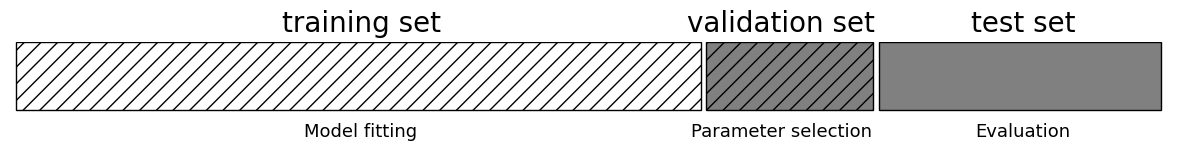

In [2]:
# 훈련 세트, 검증 세트, 테스트 세트의 3개 폴드로 나눈 데이터
mglearn.plots.plot_threefold_split()

- 검증 세트를 사용해 최적의 매개변수를 선택한 후, 그 매개변수에서 훈련 세트와 검증 세트 데이터를 모두 이용해 다시 만듦
- 이렇게 하는 이유는 모델을 만들 때 가능한 한 많은 데이터를 이용하기 위해서임

In [3]:
from sklearn.svm import SVC
# 데이터를 훈련+검증 세트 그리고 테스트 세트로 분할
X_trainval, X_test,y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print("훈련 세트의 크기: {}   검증 세트의 크기: {}    테스트 세트의 크기: {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # 매개변수의 각 조합에 댛 SVC를 훈련시킴
    svm = SVC(gamma=gamma, C=C)
    svm.fit(X_train, y_train)
    # 검증 세트로 SVC를 평가
    score = svm.score(X_valid, y_valid)
    # 점수가 더 높으면 매개변수와 함께 기록
    if score > best_score:
      best_score = score
      best_parameters = {"C": C, "gamma": gamma}

# 훈련 세트와 검증 세트를 합쳐 모델을 다시 만든 후
# 테스트 세트를 사용해 평가
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print("검증 세트에서 최고 점수: {:.2f}".format(best_score))
print("최적 매개변수: ",best_parameters)
print("최적 매개변수에서 테스트 세트 점수: {:.2f}".format(test_score))

훈련 세트의 크기: 84   검증 세트의 크기: 28    테스트 세트의 크기: 38

검증 세트에서 최고 점수: 0.96
최적 매개변수:  {'C': 10, 'gamma': 0.001}
최적 매개변수에서 테스트 세트 점수: 0.92


- 검증 세트에서 최고 점수는 96% 임
- 전보다 조금 낮아졌는데 아마도 모델을 훈련할 때 사용한 데이터가 적어졌기 때문일 것(데이터셋을 두 번 나눴으니 X_train이 더 작아짐)
- 하지만 테스트 세트 점수(실제 이 모델이 얼마나 잘 일반화됐는지 알려주는 점수)는 훨씬 낮은 92% 임
- 따라서 앞서 예상한 97%가 아니라, 새로운 데이터에 대해 92%만 정확하게 분류한다고 말할 수 있음
- 훈련 세트, 검증 세트, 테스트 세트의 구분은 실제 머신러닝 알고리즘을 적용하는 데 아주 중요
- 테스트 세트 정확도에 기초해 어떤 선택을 했다면 테스트 세트의 정보를 모델에 누설한 것
- 그렇기 때문에 최종 평가에만 사용하도록 테스트 세트를 분리해 유지하는 것이 중요
- (데이터 탐색을 위한 시각화를 포함해서) 모든 탐색적 분석과 모델 선택을 위해서는 훈련 세트와 검증 세트를 사용하는 것을 권장하며, 마지막 평가를 위해 테스트 세트를 보관하는 것이 좋음
- 정확하게 말하면 테스트 세트로 둘 이상의 모델을 평가해서 그중 더 나은 하나를 선택하는 것은 모델의 정확도를 매우 낙관적으로 추정하는 행위

## 2-3. 교차 검증을 사용한 그리드 서치
- 데이터를 훈련 세트, 검증 세트, 테스트 세트로 나누는 방법은 잘 작동하고 널리 사용되지만, 데이터를 나누는 방법에 매우 민감
- 이전 코드의 출력에서는 C: 10, gamma: 0.001을 최적의 매개변수로 선택했지만, 앞 절의 코드에서는 C:100, gamma: 0.001을 최적으로 선택
- 일반화 성능을 더 잘 평가하려면 훈련 세트와 검증 세트를 한 번만 나누지 않고, 교차 검증을 사용해서 각 매개변수 조합의 성능을 평가할 수 있음

In [4]:
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state = 1)

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # 매개 변수의 각 조합에 대해 svc를 훈련시킴
    svm = SVC(gamma=gamma, C=C)
    # 교차 검증을 적용
    scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
    # 교차 검증 정확도의 평균을 계산
    score = np.mean(scores)
    # 점수가 더 높으면 매개변수와 함께 기록
    if score > best_score:
      best_score = score
      best_parameters = {"C": C, "gamma": gamma}
# 훈련 세트와 검증 세트를 합쳐 모델을 다시 만듦
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

- 5-겹 교차 검증으로 C와 gamma 설정에 대한 SVM의 정확도를 평가하려면 36 * 5 = 180개의 모델을 만들어야 함
- 예상대로 교차 검증의 단점은 이 모델들을 모두 학습시키는 데 걸리는 시간임

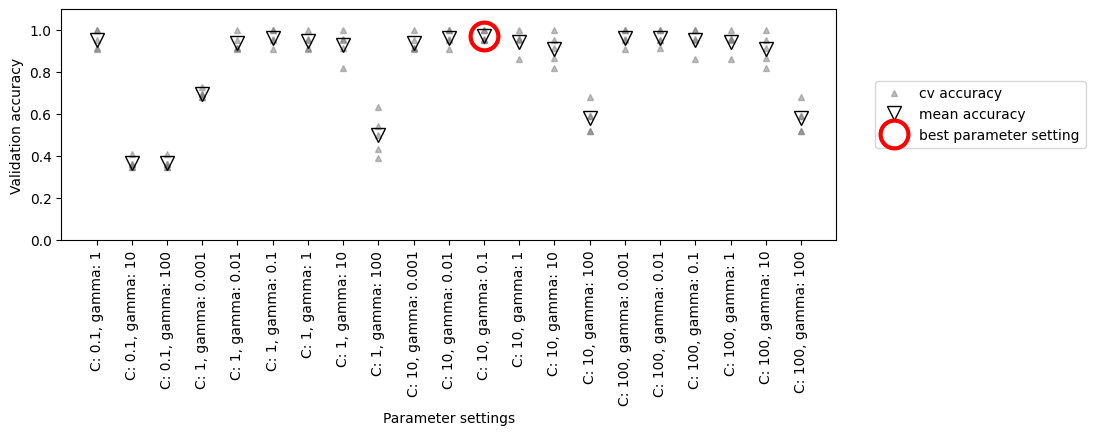

In [5]:
# 교차 검증을 사용한 그리드 서치의 결과
mglearn.plots.plot_cross_val_selection()

- 각 매개변수 설정마다 (그림에는 일부만 나타나 있음) 교차 검증 분할에 한 개씩, 모두 다섯 개의 값을 계산
- 교차 검증 정확도 평균이 가장 높은 매개변수를 동그라미로 표시
- 앞서 말한 것처럼 교차 검증은 어떤 데이터셋에 대해 주어진 알고리즘을 평가하는 방법
- 하지만 그리드 서치와 같은 매개변수 탐색 방법과 합쳐서 많이 사용함
- 그래서 많은 사람이 교차 검증이란 용어를 교차 검증을 사용한 그리드 서치라는 의미로 주로 사용

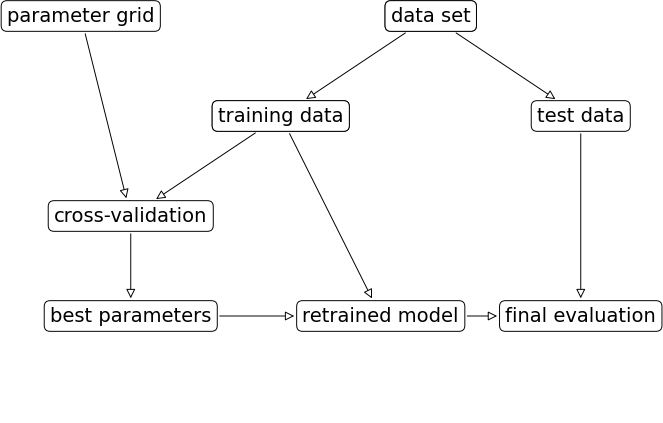

In [6]:
# 데이터를 나누고 그리드 서치를 적용하여 최종 매개변수를 평가하는 전체 과정
# 교차 검증과 그리드 서치를 사용한 매개변수 선택과 모델 평가의 작업 흐름
mglearn.plots.plot_grid_search_overview()

- 교차 검증을 사용한 그리드 서치를 매개변수 조정 방법으로 널리 사용하기 때문에 scikit-learn은 추정기 형태로 구현된 GridSearchCV를 제공하고 있음
- GridSearchCV를 사용하려면 먼저 딕셔너리 형태로 검색 대상 매개변수를 지정해야 함
- 그러면 GridSearchCV는 필요한 모든 모델을 학습시킴
- 딕셔너리의 키는 조정하고자 하는 매개변수 이름(모델 생성 시 지정할 것들, 이 경우에는 C와 gamma)이고, 값은 탐색할 매개변수의 설정값
- C와 gamma에 0.001, 0.01, 0.1, 1, 10, 100 값을 시도하려면 다음과 같은 딕셔너리를 만듦

In [7]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}
print("매개변수 그리드:\n", param_grid)

매개변수 그리드:
 {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [8]:
# 모델(SVC), 검색 대상 매개변수 그리드(param_grid), 원하는 교차 검증으로 GridSearchCV의 객체를 생성
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

iris = load_iris()
grid_search = GridSearchCV(SVC(),param_grid,cv = 5,return_train_score = True)

- 앞서 훈련 세트와 검증 세트로 한 번 분리했던 것과 달리 GridSearchCV는 교차 검증을 사용
- 그러나 매개변수가 과대적합되는 것을 피하려면 여기에서도 데이터를 훈련 세트와 테스트 세트로 나눠야 함

In [9]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

- grid_search 객체는 분류기와 비슷해서 fit, predict, score 메서드를 제공
- 하지만 fit 메서드를 호출하면 param_grid에 설정된 매개변수 조합에 대한 교차 검증을 수행

In [10]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

- GridSearchCV 객체의 fit 메서드는 최적의 매개변수를 찾는 일뿐만 아니라, 교차 검증 성능이 가장 좋은 매개변수로 전체 훈련 데이터셋에 대해 새로운 모델을 자동으로 만듦
- GridSearchCV는 전체 데이터로 학습한 모델에 접근할 수 있도록 predict와 score 메서드를 제공
- 찾은 최적 매개변수로 일반화 성능을 평가하려면 테스트 세트를 매개변수로 넘겨 score 메서드를 호출하면 됨

In [11]:
print("테스트 세트 점수: {:.2f}".format(grid_search.score(X_test, y_test)))

테스트 세트 점수: 0.97


- 교차 검증으로 매개변수를 선책하니 테스트 세트 정확도가 97%인 모델을 얻었음
- 여기서 중요한 것은 매개변수를 선택하는 데 테스트 세트를 사용하지 않았다는 것
- 선택한 매개변수는 best_params_ 속성에 담겨 있으며 최상의 교차 검증 정확도는 (이 매개변수 설정으로 각 분할에서 얻은 정확도의 평균) best_score_에 저장되어 있음

In [12]:
print("최적 매개변수:", grid_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))

최적 매개변수: {'C': 10, 'gamma': 0.1}
최고 교차 검증 점수: 0.97


- 테스트 세트로 score 메서드에서 계산하는 모델의 일반화 성능과 best_score_를 혼동해서는 안 됨
- score 메서드는 (또는 predict 메서드의 결과는) 전체 훈련 세트에서 학습한 모델에 대한 것임
- best_score_ 속성에는 훈련 세트에서 수행한 교차 검증의 평균 정확도가 저장됨
- 가끔은 만들어진 실제 모델에 직접 접근해야 할 때가 있음
- 예를 들면 계수나 특성 중요도를 살펴보려고 할 때
- 최적의 매개변수에서 전체 훈련 세트를 사용하여 학습한 모델은 best_esimator_ 속성에서 얻을 수 있음

In [13]:
print("최고 성능 모델:\n", grid_search.best_estimator_)

최고 성능 모델:
 SVC(C=10, gamma=0.1)


- grid_search 객체가 predict와 score 메서드를 가지고 있으므로 예측이나 모델 평가를 위해 best_estimator_ 속성을 사용할 필요는 없음

### 교차 검증 결과 분석
- 교차 검증의 결과를 시각화하면 검색 대상 매개변수가 모델의 일반화에 영향을 얼마나 주는지 이해하는 데 도움이 됨
- 그리드 서치는 연산 비용이 매우 크므로 비교적 간격을 넓게 하여 적은 수의 그리드로 시작하는 것이 좋음
- 그런 다음 교차 검증된 그리드 서치의 결과를 분석하여 검색을 확장해나갈 수 있음
- 그리드 서치의 결과는 검색과 관련한 여러 정보가 함께 저장되어 있는 딕셔너리인 cv_results_ 속성에 담겨 있음
- 다음 결과에서 볼 수 있듯이 이 속성에는 상세 정보가 많이 들어 있으므로 pandas의 DataFrame으로 변환해서 보는 것이 좋음

In [14]:
pd.set_option("display.max_columns", None)
# DataFrame으로 변환
results = pd.DataFrame(grid_search.cv_results_)
# 처음 다섯 개 행을 출력
np.transpose(results.head())

,0,1,2,3,4
mean_fit_time,0.001074,0.001274,0.0011,0.001224,0.001711
std_fit_time,0.000086,0.000446,0.000175,0.000424,0.001701
mean_score_time,0.000915,0.001116,0.0005,0.0002,0.000193
std_score_time,0.000175,0.000193,0.000633,0.0004,0.000246
param_C,0.001,0.001,0.001,0.001,0.001
param_gamma,0.001,0.01,0.1,1,10
params,"{'C': 0.001, 'gamma': 0.001}","{'C': 0.001, 'gamma': 0.01}","{'C': 0.001, 'gamma': 0.1}","{'C': 0.001, 'gamma': 1}","{'C': 0.001, 'gamma': 10}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826
split2_test_score,0.363636,0.363636,0.363636,0.363636,0.363636


- results의 행 하나는 특정한 하나의 매개변수 설정에 대응
- 각 설정에 대해 교차 검증의 모든 분할의 평균값, 표준편차를 포함한 결과가 기록되어 있음
- 검색 대상 매개변수 그리드가 2차원이므로(C와 gamma), 히트맵으로 시각화하기가 좋음
- 먼저 교차 검증의 평균을 뽑아서 C와 gamma 축에 맞도록 배열 차원을 바꿈

TypeError: Only length-1 arrays can be converted to Python scalars

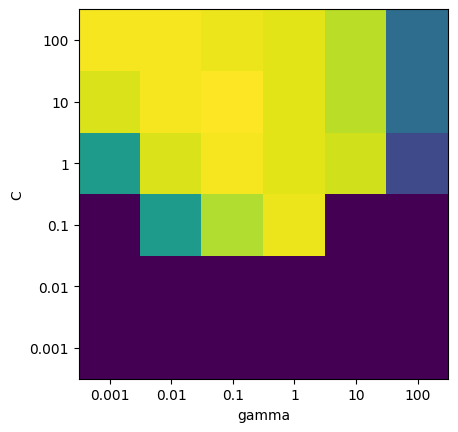

In [15]:
scores = np.array(results.mean_test_score).reshape(6,6)

# C와 gamma 값에 따른 교차 검증 평균 점수의 히트맵
mglearn.tools.heatmap(scores,xlabel = 'gamma',xticklabels=param_grid['gamma'], ylabel = 'C',yticklabels = param_grid['C'],cmap = "viridis")

- 히트맵의 각 포인트는 특정 매개변수 설정에 대한 교차 검증 실행을 나타냄
- 교차 검증의 정확도가 높으면 밝은 색으로, 낮으면 어두운 색으로 나타냈음
- 그래프를 보면 SVC가 매개변수 설정에 매우 민감함을 알 수 있음
- 많은 매개변수 설정에서 40% 부근의 낮은 정확도를 내고 있지만 어떤 설정에서는 96% 이상을 만들었음
- 이 그래프에서 몇 가지 정보를 얻을 수 있음
- 먼저 높은 성능을 얻으려면 매개변수 조정이 매우 중요하다는 것
- 두 매개변수 (C와 gamma)가 매우 중요하며 어떻게 조정하는지에 따라 정확도가 40%에서 96%까지 차이가 남
- 또 선택한 매개변수 그리드의 범위에서 결과값이 크게 변하고 있음
- 즉, 각 매개변수의 최적값이 그래프 끝에 놓이지 않도록 매개변수의 범위가 충분히 넓다는 점이 중요

TypeError: Only length-1 arrays can be converted to Python scalars

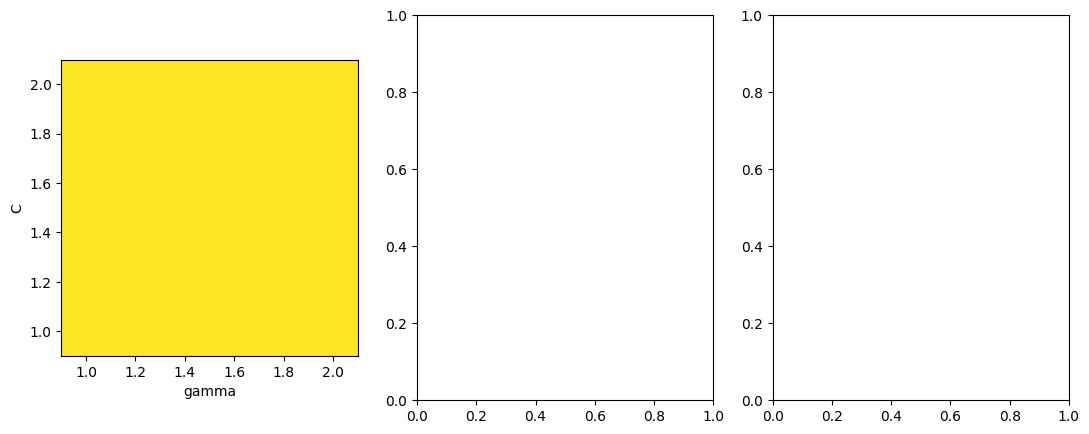

In [16]:
# 적절하지 않은 매개변수 그리드의 히트맵
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

param_grid_linear = {'C' : np.linspace(1,2,6),'gamma' : np.linspace(1,2,6)}
param_grid_one_log = {'C' : np.linspace(1,2,6),'gamma' : np.logspace(-3,2,6)}
param_grid_range = {'C' : np.logspace(-3,2,6),'gamma' : np.logspace(-7,-2,6)}

for param_grid, ax in zip([param_grid_linear,param_grid_one_log,
                           param_grid_range],axes):
    grid_search = GridSearchCV(SVC(),param_grid, cv = 5)
    grid_search.fit(X_train,y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6,6)

  # 교차 검증 평균 점수의 히트맵 그래프
    scores_image = mglearn.tools.heatmap(scores,xlabel = 'gamma',ylabel = 'C',xticklabels = param_grid['gamma'], yticklabels = param_grid['C'],cmap = 'viridis',ax = ax, vmin = 0.3,vmax = 0.9)
plt.colorbar(scores_image,ax = axes.tolist())

- 첫 번째 그래프는 점수 변화가 전혀 없어서 ㅈ너체 매개변수 그리드가 같은 색
- 이런 결과는 매개변수 C와 gamma의 스케일과 범위가 부적절할 때 발생
- 그러나 매개변수 설정이 바뀌어도 정확도에 아무런 변화가 없다면, 그 매개변수가 전혀 중요하지 않은 것일 수도 있음
- 처음에는 매우 극단적인 값을 적용해보고, 매개변수를 바꿔가며 정확도가 변하는지 살펴보는 것이 좋음
- 두 번째 그래프는 세로 띠 형태를 보이고, 이는 gamma 매개변수만 정확도에 영향을 준다는 뜻
- 즉 gamma 매개변수는 적절한 범위를 탐색하고 있지만, C 매개변수는 그렇지 못하든지, 아니면 중요한 매개변수가 아닐 수도 있음
- 세 번째 그래프는 C와 gamma 둘 모두에 따라 값이 변했음
- 하지만 그래프의 왼쪽 아래 영역에서는 아무런 변화가 없음
- 아마도 다음 번 검색 땐 매개변수 그리드에서 매우 작은 단위는 제외될 것
- 최적치가 그래프의 경계에 있으니 이 경계 너머에 더 나은 값이 있다고 생각할 수 있음
- 그러니 이 영역이 포함되도록 매개변수 검색 범위를 바꿔줘야 함
- 교차 검증 점수를 토대로 매개변수 그리드를 튜닝하는 것은 아주 안전한 방법이며, 매개변수들의 중요도를 확인하는 데도 좋음
- 그러나 최종 테스트 세트를 대상으로 여러 매개변수 범위를 테스트해서는 안 됨
- 앞서 이야기했지만, 테스트 세트 평가는 사용할 모델이 정확히 결정되고 나서 딱 한 번만 해야 함

### 비대칭 매개변수 그리드 탐색
- 어떤 경우에는 모든 매개변수의 조합에 대해 GridSearchCV를 수행하는 것이 좋은 생각이 아닐 수 있음
- 예를 들어 SVC는 kernel 매개변수를 가지고 있는데 어떤 커널을 사용하는지에 따라 관련 있는 매개변수들이 결점됨
- kernel='leaner'이면 선형 모델이고 C 매개변수만 사용
- kernel='rbf'이면 C와 gamma를 모두 사용(하지만 degree 같은 다른 매개변수는 사용하지 않음)
- 이런 경우에 C, gamma, kernel 매개변수의 모든 조합을 조사하는 것은 맞지 않음
- kernel='linear'이면 gamma를 사용하지 않으므로 gamma의 값에 대해 조사하는 것은 시간 낭비임
- 이런 조건부 매개변수 조합을 적용하려면 GridSearchCV에 전달할 param_grid를 딕셔너리의 리스트로 만들어주면 됨
- 리스트에 있는 각 딕셔너리는 독립적인 그리드로 적용됨

In [17]:
# kernel을 포함한 매개변수 그리드의 예
param_grid = [{"kernel": ["rbf"], "C": [0.001, 0.01, 0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}, {"kernel": ["linear"], "C": [0.001, 0.01, 0.1, 1, 10, 100]}]
print("그리드 목록:\n", param_grid)

그리드 목록:
 [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


- 첫 번째 그리드에서 kernel 매개변수는 rbf로 고정되고 (kernel 항목의 리스트 길이가 1임), C와 gamma 두 매개변수는 바뀜
- 두 번째 그리드에서 kernel 매개변수는 항상 linear로 고정되고 C만 바뀜

In [18]:
# 이 매개변수 그리드를 적용
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
print("최적 파라미터:", grid_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))

최적 파라미터: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
최고 교차 검증 점수: 0.97


In [19]:
# 예상대로 kernel이 linear일 땐 C만 변경되었음
results = pd.DataFrame(grid_search.cv_results_)
# 좀 더 나은 출력을 위해 결과를 전치시킴
results.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.000797,0.000654,0.000101,0.000504,0.000661,0.000392,0.000424,0.0,0.001791,0.00012,0.001539,0.000734,0.000576,0.00136,0.000215,0.001723,0.001144,0.001164,0.001702,0.0,0.000225,0.000915,0.002224,0.000378,0.000203,0.000208,0.0,0.000229,0.0,0.000748,0.0,0.00153,0.000963,0.0,0.001185,0.001189,0.001936,0.001622,0.000611,0.0,0.000185,0.001215
std_fit_time,0.000401,0.000543,0.000202,0.001008,0.00081,0.000784,0.000848,0.0,0.003582,0.00024,0.002347,0.001468,0.001153,0.001533,0.000431,0.003446,0.002287,0.00179,0.003405,0.0,0.000451,0.00183,0.003221,0.000757,0.000407,0.000415,0.0,0.000459,0.0,0.001496,0.0,0.001882,0.001927,0.0,0.002012,0.001986,0.003873,0.003245,0.001222,0.0,0.000371,0.001962
mean_score_time,0.001555,0.000518,0.000227,0.002049,0.0002,0.0,0.001198,0.0,0.0,0.001147,0.000207,0.0,0.0,0.000314,0.0,0.000625,0.0,0.000326,0.00193,0.0,0.000257,0.000215,0.001017,0.001332,0.000064,0.000192,0.0,0.001223,0.001893,0.000183,0.0,0.000168,0.0002,0.001656,0.000575,0.000309,0.000201,0.000035,0.000155,0.0,0.00024,0.000137
std_score_time,0.000775,0.000457,0.000455,0.003617,0.000401,0.0,0.00199,0.0,0.0,0.002294,0.000413,0.0,0.0,0.000628,0.0,0.00125,0.0,0.000652,0.003861,0.0,0.000514,0.00043,0.002034,0.001984,0.000127,0.000384,0.0,0.001986,0.003785,0.000367,0.0,0.000335,0.000401,0.003313,0.001151,0.000617,0.000403,0.00007,0.000309,0.0,0.00048,0.000274
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,0.1,1,1,1,1,1,1,10,10,10,10,10,10,100,100,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 10, 'kernel': 'rbf'}","{'C': 10, 'gamma': 100, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.695652,0.913043,1.0,0.347826,0

### 그리드 서치에 다양한 교차 검증 적용
- cross_val_score와 비슷하게, GridSearchCV는 분류에는 기본적으로 계층형 k-겹 교차 검증을 사용하고 회귀에는 k-겹 교차 검증을 사용
- 그러나 GridSearchCV의 cv 매개변수를 통해 330페이지의 "교차 검증 상세 옵션" 절에 나온 다른 교차 검증 분할기를 사용할 수도 있음
- 특별히 훈련 세트와 검증 세트로 한 번만 분할하려면 n_splits=1로 하고 ShuffleSplit나 StratifiedShuffleSplit를 사용
- 이런 방법은 데이터셋이 매우 크거나 모델 구축에 시간이 오래 걸릴 때 유용

### 중첩 교차 검증 (Nested Cross-Validation)
- 앞선 예에서 데이터를 한 번에 훈련, 검증, 데이터 세트로 나눈 방식에서, 훈련 세트와 테스트 세트로 나눈 다음 훈련 세트로 교차 검증을 수행하는 방식으로 바꿨음
- 하지만 GridSearchCV를 사용할 때 여전히 데이터를 훈련 세트와 테스트 세트로 한 번만 나누기 때문에, 결과가 불안정하고 테스트 데이터의 분할에 크게 의존
- 원본 데이터를 훈련 세트와 테스트 세트로 한 번만 나누는 방식 대신 더 나아가 교차 검증 분할 방식을 사용할 수 있음
- 이를 중첩 교차 검증이라고 하고, 중첩 교차 검증에서는 바깥쪽 루프에서 데이터를 훈련 세트와 테스트 세트로 나눔
- 그리고 각 훈련 세트에 대해 그리드 서치를 실행 (아마도 바깥쪽 루프에서 분할된 훈련 세트마다 최적의 매개변수가 다를 것)
- 그런 다음 바깥쪽에서 분할된 테스트 세트의 점수를 최적의 매개변수 설정을 사용해 각각 측정
- 이 방법은 모델이나 매개변수 설정이 아닌 테스트 점수의 목록을 만들어 줌
- 이 점수들은 그리드 서치를 통해 찾은 최적 매개변수가 모델을 얼마나 잘 일반화시키는지 알려줌
- 새로운 데이터에 적용할 모델을 만드는 것이 아니니, 중첩 교차 검증은 미래 데이터에 적용하기 위한 예측 모델을 찾는 데는 거의 사용하지 않음
- 그러나 특정 데이터셋에서 주어진 모델이 얼마나 잘 일반화되는지 평가하는 데 유용한 방법임
- scikit-learn을 활용하면 중첩 교차 검증을 직관적으로 구현할 수 있음
- GridSearchCV의 객체를 모델로 삼아 cross_val_score 함수를 호출

In [20]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)
print("교차 검증 점수: ", scores)
print("교차 검증 평균 점수: ", scores.mean())

교차 검증 점수:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
교차 검증 평균 점수:  0.9800000000000001


- 중첩 교차 검증의 결과를 요약하면 "SVC는 iris 데이터셋에서 평균 교차 검증 정확도가 98%다"라고 할 수 있으며, 그 이상도 이하도 아님
- 여기에서 안쪽 루프와 바깥쪽 루프에 각각 계층형 5-겹 교차 검증을 사용했음
- param_grid의 매개변수 조합은 36개
- 이때 만들어지는 모델은 총 36 * 5 * 5 = 900개나 되므로 중첩 교차 검증은 매우 비싼 방법임
- 여기서 안쪽 루프와 바깥쪽 루프에 같은 교차 검증 분할기를 사용했음
- 하지만 꼭 이렇게 해야 하는 것은 아니므로 안쪽과 바깥쪽 루프에 각기 다른 교차 검증 전략을 조합해 사용할 수 있음
- 이 한줄짜리 코드에서 어떤 작업이 일어나는지 이해하기가 좀 어렵지만, 아래 예처럼 for문을 사용하여 간단하게 구현해보면 이해하는 데 도움이 됨

In [21]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
  outer_scores = []
  # outer_cv의 분할을 순회하는 for 루프
  # (split 메서드는 훈련과 테스트 세트에 해당하는 인덱스를 반환)
  for train_samples, test_samples in outer_cv.split(X, y):
    # 최적의 매개변수를 찾음
    best_params = {}
    best_score = -np.inf
    # 매개변수 그리드를 순회
    for parameters in parameter_grid:
      # 안쪽 교차 검증의 점수를 기록
      cv_scores = []
      # inner_cv의 분할을 순회하는 for 루프
      for inner_train, inner_test in inner_cv.split(X[train_samples], y[train_samples]):
        # 훈련 데이터와 주어진 매개변수로 분류기를 만듦
        clf = Classifier(**parameters)
        clf.fit(X[inner_train], y[inner_train])
        # 검증 세트로 평가
        score = clf.score(X[inner_test], y[inner_test])
        cv_scores.append(score)
      # 안쪽 교차 검증의 평균 점수를 계산
      mean_score = np.mean(cv_scores)
      if mean_score > best_score:
        # 점수가 더 높으면 매개변수와 함께 기록
        best_score = mean_score
        best_params = parameters
    # 바깥쪽 훈련 데이터 전체를 사용해 분류기를 만듦
    clf = Classifier(**best_params)
    clf.fit(X[train_samples], y[train_samples])
    # 테스트 세트를 사용해 평가
    outer_scores.append(clf.score(X[test_samples], y[test_samples]))
  return np.array(outer_scores)

In [22]:
# 이 함수를 iris 데이터셋에 적용
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5), StratifiedKFold(5), SVC, ParameterGrid(param_grid))

print("교차 검증 점수:", scores)

교차 검증 점수: [0.96666667 1.         0.96666667 0.96666667 1.        ]


### 교차 검증과 그리드 서치 병렬화
- 그리드 서치는 데이터 용량이 크고 매개변수 수도 많을 때는 상당한 연산 부하를 일으키지만, 다행히 쉽게 병렬화할 수 있음
- 하나의 교차 검증 분할에서 특정 매개변수 설정을 사용해 모델을 만드는 일은 다른 매개변수 설정이나 모델과 전혀 상관없이 진행할 수 있기 때문
- 그러므로 그리드 서치와 교차 검증은 여러 CPU 코어 또는 클러스터에 병렬화하기 좋음
- GridSearchCV와 cross_val_score에서 n_jobs 매개변수에 사용할 CPU 코어 수를 지정할 수 있음
- n_jobs=-1이면 가능한 모든 코어를 사용
- 아직 충분히 테스트되지는 않았지만, 모델과 GridSearchCV에 모두 n_jobs 매개변수를 지정할 수 있음
- 데이터셋과 모델이 매우 클 때는 여러 코어를 사용하면 너무 많은 메모리를 차지함
- 그래서 대규모 모델을 병렬로 만들 땐 메모리 사용 현황을 모니터링하는 것이 좋음
- 분산 컴퓨팅 패키지인 Dask를 사용하여 클러스터의 여러 머신에서 그리드 서치와 교차 검증을 병렬화할 수도 있음

- GridSearchCV 외에 널리 사용하는 또 하나의 방식으로, 주어진 범위에서 매개변수를 무작위로 선택해 조사하는 RandomizedSearchCV가 있음
- RandomizedSearchCV의 경과가 GridSearchCV보다 크게 뒤지지 않고 검색이 빠르기 때문에, 매개변수의 조합이 매우 많거나 규제 매개변수 C와 같이 연속형 값을 조정해야 할 때 널리 사용함
- 이 클래스는 n_iter 매개변수(기본값 10)로 탐색 횟수를 조정할 수 있어 컴퓨팅 자원에 맞게 탐색을 실행할 수 있음
- GridSearchCV 클래스에는 탐색할 매개변수 값을 리스트로 전달
- RandomizedSearchCV에는 샘플링 가능한 분포를 지정해야 함
- 예를 들어 scipy.stats.uniform, spicy.stats.randint 객체 등이 있음
- 앞서 비대칭 매개변수 그리드 탐색에서 사용한 것과 동일한 범위(0.01~100)를 RandomizedSearchCV로 탐색
- 먼저 logunifrom 함수로 탐색할 파라미터 그리드를 정의

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_dist = [{"kernel": ["rbf"], "C": loguniform(0.001, 100), "gamma": loguniform(0.001, 100)}, {"kernel": ["linear"], "C": loguniform(0.001, 100)}]

In [25]:
# n_iter=20으로 지정하여 탐색 횟수를 20번으로 제한하여 RandomizedSearchCV를 실행
rand_search = RandomizedSearchCV(SVC(), param_dist, n_iter=20, random_state=42, n_jobs=-1)
rand_search.fit(X_train, y_train)
print("최적 파라미터:", rand_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(rand_search.best_score_))

최적 파라미터: {'C': 1.7965626423790644, 'kernel': 'linear'}
최고 교차 검증 점수: 0.97


- SH(Successive Halving) 방식의 HalvingGridSearchCV 클래스는 모든 파라미터 조합에 대해 제한된 지원으로 그리드서치를 실행한 다음 가장 좋은 후보를 골라서 더 많은 자원을 투여하는 식으로 반복적으로 탐색을 수행하고, 이런 방식을 SH라고 부름
- HalvingGridSearchCV의 resource 매개변수는 반복마다 늘려 갈 자원을 정의
- 기본값은 "n_samples"로 샘플 갯수
- 이외에도 탐색 대상 모델에서 양의 정수 값을 가진 매개변수를 지정할 수 있음
- 예를 들어 랜덤 포레스트의 n_estimators가 가능
- factor 매개변수는 반복마다 선택할 후보의 비율을 지정. 기본값 3으로 후보 중에서 성능이 높은 1/3만 다음 반복으로 전달함

In [26]:
# verbose=1로 지정하고 각 반복 과정을 살펴봄
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

param_grid = [{"kernel": ["rbf"], "C": [0.001, 0.01, 0.1, 1, 10, 100], "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}, {"kernel": ["linear"], "C": [0.001, 0.01, 0.1, 1, 10, 100]}]
halv_search = HalvingGridSearchCV(SVC(), param_grid, verbose=1, random_state=42, n_jobs=-1)
halv_search.fit(X_train, y_train)
print()
print("최적 파라미터:", halv_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(halv_search.best_score_))

n_iterations: 2
n_required_iterations: 4
n_possible_iterations: 2
min_resources_: 30
max_resources_: 112
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 42
n_resources: 30
Fitting 5 folds for each of 42 candidates, totalling 210 fits
----------
iter: 1
n_candidates: 14
n_resources: 90
Fitting 5 folds for each of 14 candidates, totalling 70 fits

최적 파라미터: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
최고 교차 검증 점수: 0.97


- 출력 결과를 보면 첫 번째 반복(iter: 0)에서 42개의 후보를 30개의 샘플로 교차 검증을 수행함
- 기본적으로 첫 번째 반복에서 사용하는 샘플 갯수는 회귀일 때는 cv 횟수의 두 배이고 분류일 경우에는 클래스 개수를 더 곱함
- 여기에서는 기본 5-겹 교차 검증을 사용하고 붓꽃 분류 문제이므로 클래스가 3개임
- 따라서 첫 번째 반복에서 사용하는 샘플 갯수는 5 * 2 * 2 = 30개임
- 첫 번째 반복에서 가장 좋은 성능의 42 / 3 = 14개의 후보를 뽑아 두 번째 반복(iter: 1)에서 샘플 갯수를 factor 배만큼 늘려서 교차 검증을 수행
- 즉 30 * 3 = 90개의 샘플을 사용. 전체 샘플 갯수(112개)보다 작으면서 factor 배만큼 반복할 수 있는 최대 크기이므로 알고리즘이 멈추고 가장 좋은 파라미터 조합을 best_params_에 저장
- HalvingGridSearchCV가 수행한 전체 교차 검증 횟수는 42 + 14 = 56회로 그리드 서치보다 많지만 사용한 샘플 갯수가 적기 때문에 훨씬 빠르게 실행됨
- 각 단계의 지원과 후보 갯수를 확인하려면 n_resources_속성과 n_candidates_ 속성을 확인

In [27]:
print("자원 리스트", halv_search.n_resources_)
print("후보 리스트:", halv_search.n_candidates_)

자원 리스트 [30, 90]
후보 리스트: [42, 14]
